In [0]:
#https://www.tensorflow.org/tutorials/estimator/linear

#Overview

This end-to-end walkthrough trains a logistic regression model using the tf.estimator API. The model is often used as a baseline for other, more complex, algorithms.

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


In [0]:
!pip install -q sklearn
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

#Load the titanic dataset

(This dataset could be just a simple csv with columns, rows and a label column)

You will use the Titanic dataset with the (rather morbid) goal of predicting passenger survival, given characteristics such as gender, age, class, etc.

In [0]:
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [0]:
# Load dataset.
#A simple train (columns) and eval (lablel) dataset from google csv
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


#Explore the data

The dataset contains the following features

In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [7]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [8]:
#simply the size of the 'rows' train and evaluation
dftrain.shape[0], dfeval.shape[0]

(627, 264)

In [9]:
#note, the shaoe is 627 rows by 9 columns
dftrain.shape

(627, 9)

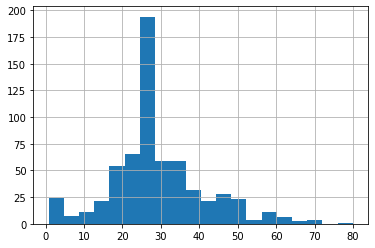

In [10]:
#Checking some characteristics of the data
dftrain.age.hist(bins=20)

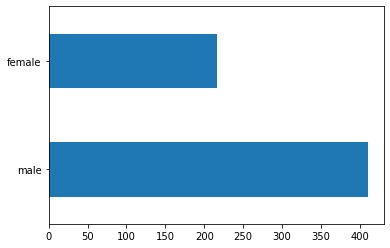

In [11]:
dftrain.sex.value_counts().plot(kind='barh')

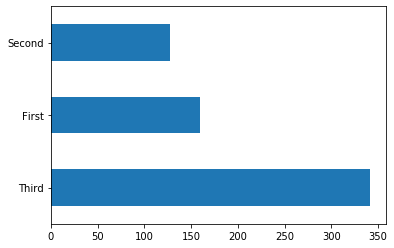

In [12]:
dftrain['class'].value_counts().plot(kind='barh')


Text(0.5, 0, '% survive')

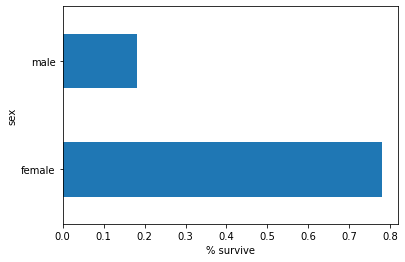

In [13]:
#checking the mean of the gender of the survivors
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

#Feature Engineering for the Model

Estimators use a system called feature columns to describe how the model should interpret each of the raw input features. An Estimator expects a vector of numeric inputs, and feature columns describe how the model should convert each feature.

Selecting and crafting the right set of feature columns is key to learning an effective model. A feature column can be either one of the raw inputs in the original features dict (a base feature column), or any new columns created using transformations defined over one or multiple base columns (a derived feature columns).

The linear estimator uses both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally, they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization.

In [0]:
#Base Feature Columns
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone'] #the categorial column names
NUMERIC_COLUMNS = ['age', 'fare'] #the numerical column names

feature_columns = [] #creating the feature column array
for feature_name in CATEGORICAL_COLUMNS: #getting the categorical column names
  vocabulary = dftrain[feature_name].unique() #creating a vocabilary, which is basically all the possibilities of categories in the column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) #
  #this creates a column of type VocabularyListCategoricalColumn, with the column name as 'key' and its possibilites as the vocabulary

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32)) #a numeric column


In [15]:
feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

The `input_function` specifies how data is converted to a `tf.data.Dataset `that feeds the input pipeline in a streaming fashion. `tf.data.Dataset` can take in multiple sources such as a dataframe, a csv-formatted file, and more.

In [0]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) #creando un BatchDataset
    if shuffle:
      ds = ds.shuffle(1000) #shuffling the dataset
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

#generate the train and eval datasets into BatchDatasets
train_input_fn = make_input_fn(dftrain, y_train) 
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False) #num_epoch = 1 because we are just evaluating prediction vs reality once


In [17]:
#Inspecting the dataset
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())


Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'First' b'Third' b'Third' b'Third' b'Third' b'Third' b'First' b'Second'
 b'First' b'Third']

A batch of Labels: [1 0 0 0 1 0 0 1 1 0]


In [18]:
#You can also inspect the result of a specific feature column using the tf.keras.layers.DenseFeatures layer:
age_column = feature_columns[7] #feature_columns[7] just returns a single numeric column, in this case 'age'
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy() #I think this just returns the ages of a single batch
#The batch was taken randomly previously, we are just taking the ages in a ¿easy to read? format



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[33.],
       [28.],
       [25.],
       [21.],
       [ 1.],
       [28.],
       [49.],
       [24.],
       [18.],
       [28.]], dtype=float32)

In [19]:
#DenseFeatures only accepts dense tensors, to inspect a categorical column you need to transform that to a indicator column first:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()
#So this transforms from vocabularylist.... column into a indicator_column



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

After adding all the base features to the model, let's train the model. Training a model is just a single command using the `tf.estimator` API:

In [20]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns) #Simply pass the feature_columns to the estimator #The columns are still a vocabulary btw
linear_est.train(train_input_fn) #train the model, the train_input_fn is a BatchDataset but not really, in reality it is a input_function
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)


{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.8341292, 'auc_precision_recall': 0.7904382, 'average_loss': 0.4741595, 'label/mean': 0.375, 'loss': 0.46661568, 'precision': 0.6701031, 'prediction/mean': 0.38025618, 'recall': 0.65656567, 'global_step': 200}


#Derived Feature Columns

Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. For example, the correlation between gender and the label may be different for different gender. Therefore, if you only learn a single model weight for gender="Male" and gender="Female", you won't capture every age-gender combination (e.g. distinguishing between gender="Male" AND age="30" AND gender="Male" AND age="40").

To learn the differences between different feature combinations, you can add crossed feature columns to the model (you can also bucketize age column before the cross column):

In [21]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)
age_x_gender

CrossedColumn(keys=('age', 'sex'), hash_bucket_size=100, hash_key=None)

In [22]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)


{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.84573, 'auc_precision_recall': 0.78747135, 'average_loss': 0.47230226, 'label/mean': 0.375, 'loss': 0.46512318, 'precision': 0.66346157, 'prediction/mean': 0.41135076, 'recall': 0.6969697, 'global_step': 200}


It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. You can try using more features and transformations to see if you can do better!

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier, the eval_input_fn was defined using the entire evaluation set.

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpywak642f/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


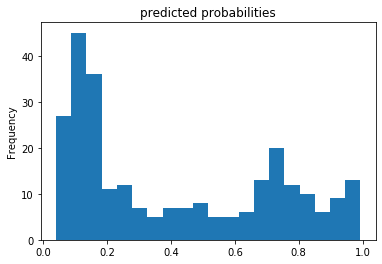

In [23]:
pred_dicts = list(linear_est.predict(eval_input_fn)) #returns a list with all the prediction characteristics
#probability, predicted class, all possibilites, etc...
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts]) #creates a series with all the probabilities (survive or no survive)
probs.plot(kind='hist', bins=20, title='predicted probabilities') #create histogram


Finally, look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.

(0, 1.05)

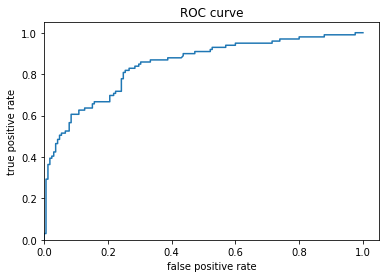

In [24]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
#note: ROC curve: https://en.wikipedia.org/wiki/Receiver_operating_characteristic
#https://www.youtube.com/watch?v=egTNM8NSa2k
#A perfect text is vertical at x = 0 then horizontal (basically starts with 1)
#A useless text is just slope = 1 (the model is just tossing a coin)
#The line is made of a treshold, i think this treshhold is the probability.
#Basically at every probability, you are checking if it was a real positive or negative??
#True positive es sensitivity y false positive es 1-especificity: https://en.wikipedia.org/wiki/Sensitivity_and_specificity
#Sensitivity: proportion of actual positives correctly identified as such
#Specificity : proportion of actual negatives that are correctly identified as such. Pero es 1-
#si true positive = 1, es que todos los sí que dijiste efectivamente eran sí?
#https://www.youtube.com/watch?v=4jRBRDbJemM
fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)


In [25]:
probs

0      0.127645
1      0.476361
2      0.776232
3      0.691755
4      0.293656
         ...   
259    0.810880
260    0.089930
261    0.525203
262    0.298401
263    0.504440
Length: 264, dtype: float64